In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc

matplotlib settings

In [2]:

labelpad = -75 # colorbar() title pad

In [3]:
# Path to the model directory
model_path = "/home/kugelblitz/runs/strak_test"

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
if not os.path.isdir(output_path):
    os.makedirs(output_path)

In [4]:
def _read_parameters(parameters_file):
    """
    Read parameters file
    .. warning :
        The parameters file contains the length of the region along each axe.
        While creating the region, we are assuming that the z axe points upwards
        and therefore all values beneath the surface are negative, and the x
        and y axes are all positive within the region.
    Parameters
    ----------
    parameters_file : str
        Path to the location of the parameters file.
    Returns
    -------
    parameters : dict
        Dictionary containing the parameters of Mandyoc files.
    """
    parameters = {}
    with open(parameters_file, "r") as params_file:
        for line in params_file:
            # Skip blank lines
            if not line.strip():
                continue
            if line[0] == "#":
                continue
            # Remove comments lines
            line = line.split("#")[0].split()
            var_name, var_value = line[0], line[2]
            parameters[var_name.strip()] = var_value.strip()
        # Add shape
        parameters["shape"] = (int(parameters["nx"]), int(parameters["nz"]))
        # Add dimension
        parameters["dimension"] = len(parameters["shape"])
        # Add region
        parameters["region"] = (
            0,
            float(parameters["lx"]),
            -float(parameters["lz"]),
            0,
        )
        parameters["step_max"] = int(parameters["step_max"])
        parameters["time_max"] = float(parameters["time_max"])
        parameters["print_step"] = int(parameters["step_print"])
        # Add units
        parameters["coords_units"] = "m"
        parameters["times_units"] = "Ma"
        parameters["temperature_units"] = "C"
        parameters["density_units"] = "kg/m^3"
        parameters["heat_units"] = "W/m^3"
        parameters["viscosity_units"] = "Pa s"
        parameters["strain_rate_units"] = "s^(-1)"
        parameters["pressure_units"] = "Pa"
    return parameters


def _read_times(path, print_step, max_steps, steps_slice):
    """
    Read the time files generated by Mandyoc code
    Parameters
    ----------
    path : str
        Path to the folder where the Mandyoc files are located.
    print_step : int
        Only steps multiple of ``print_step`` are saved by Mandyoc.
    max_steps : int
        Maximum number of steps. Mandyoc could break computation before the
        ``max_steps`` are run if the maximum time is reached. This quantity only
        bounds the number of time files.
    steps_slice : tuple
        Slice of steps (min_steps_slice, max_steps_slice). If it is None,
        min_step_slice = 0 and max_steps_slice = max_steps.
    Returns
    -------
    steps : numpy array
        Array containing the saved steps.
    times : numpy array
        Array containing the time of each step in Ma.
    """
    steps, times = [], []
    # Define the mininun and maximun step
    if steps_slice is not None:
        min_steps_slice, max_steps_slice = steps_slice[:]
    else:
        min_steps_slice, max_steps_slice = 0, max_steps
    for step in range(min_steps_slice, max_steps_slice + print_step, print_step):
        filename = os.path.join(path, "{}{}.txt".format(TIMES_BASENAME, step))
        if not os.path.isfile(filename):
            break
        time = np.loadtxt(filename, unpack=True, delimiter=":", usecols=(1))
        if time.shape == ():
            times.append(time)
        else:
            time = time[0]
            times.append(time)
        steps.append(step)

    # Transforms lists to arrays
    times = 1e-6 * np.array(times)  # convert time units into Ma
    steps = np.array(steps, dtype=int)
    return steps, times

In [5]:
BASENAMES = {
    "temperature": "temperature",
    "density": "density",
    "radiogenic_heat": "heat",
    "viscosity": "viscosity",
    "strain": "strain",
    "strain_rate": "strain_rate",
    "pressure": "pressure",
    "surface": "surface",
    "velocity": "velocity",
}
DATASETS = (
    "temperature",
    "density",
    "radiogenic_heat",
    "viscosity",
    "strain",
    "strain_rate",
    "pressure",
    "surface",
    "velocity",
)
PARAMETERS_FILE = "param.txt"
TIMES_BASENAME = "time_"
# Define which datasets are scalars measured on the nodes of the grid, e.g.
# velocity is not a scalar.
SCALARS_ON_NODES = DATASETS[:6]

def read_mandyoc_output(
    path,
    parameters_file=PARAMETERS_FILE,
    datasets=DATASETS,
    steps_slice=None,
    filetype="ascii",
):
    """
    Read the files  generate by Mandyoc code
    Parameters
    ----------
    path : str
        Path to the folder where the Mandyoc files are located.
    parameters_file : str (optional)
        Name of the parameters file. It must be located inside the ``path``
        directory.
        Default to ``"param.txt"``.
    datasets : tuple (optional)
        Tuple containing the datasets that wants to be loaded.
        The available datasets are:
            - ``temperature``
            - ``density"``
            - ``radiogenic_heat``
            - ``strain``
            - ``strain_rate``
            - ``pressure``
            - ``viscosity``
            - ``velocity``
            - ``surface``
        By default, every dataset will be read.
    steps_slice : tuple
        Slice of steps to generate the step array. If it is None, it is taken
        from the folder where the Mandyoc files are located.
    filetype : str
        Files format to be read. Default to ``"ascii"``.
    Returns
    -------
    dataset :  :class:`xarray.Dataset`
        Dataset containing data generated by Mandyoc code.
    """
    # Check valid filetype
    # _check_filetype(filetype)
    # Read parameters
    parameters = _read_parameters(os.path.join(path, parameters_file))
    # Build coordinates
    shape = parameters["shape"]
    coordinates = _build_coordinates(region=parameters["region"], shape=shape)
    # Get array of times and steps
    steps, times = _read_times(
        path,
        parameters["print_step"],
        parameters["step_max"],
        steps_slice,
    )
    # Create the coordinates dictionary containing the coordinates of the nodes
    # and the time and step arrays. Then create data_vars dictionary containing
    # the desired scalars datasets.
    coords = {"time": times, "step": ("time", steps)}
    dims = ("time", "x", "z")
    profile_dims = ("time", "x")
    coords["x"], coords["z"] = coordinates[:]

    # Create a dictionary containing the scalar data (no velocity or surface)
    data_vars = {
        scalar: (
            dims,
            _read_scalars(path, shape, steps, quantity=scalar, filetype=filetype),
        )
        for scalar in datasets
        if scalar in SCALARS_ON_NODES
    }
    
    # Read surface if needed
    if "surface" in datasets:
        surface = _read_surface(path, shape[0], steps, filetype)
        data_vars["surface"] = (profile_dims, surface)

    # Read velocity if needed
    if "velocity" in datasets:
        velocities = _read_velocity(path, shape, steps, filetype)
        data_vars["velocity_x"] = (dims, velocities[0])
        data_vars["velocity_z"] = (dims, velocities[1])

    return xr.Dataset(data_vars, coords=coords, attrs=parameters)

def _build_coordinates(region, shape):
    """
    Create grid coordinates
    Parameters
    ----------
    region : tuple
        Boundary coordinates for each direction.
        If reading 2D data, they must be passed in the following order:
        ``x_min``, ``x_max``, ``z_min``, ``z_max``.
        All coordinates should be in meters.
    shape : tuple
        Number of points for each direction.
        If reading 2D data, they must be passed in the following
        order: ``nx``, ``nz``.
    Returns
    -------
    coordinates : tuple
        Tuple containing grid coordinates in the following order:
        ``x``, ``z`` if 2D.
        All coordinates are in meters.
    """
    # Get number of dimensions
    x_min, x_max, z_min, z_max = region[:]
    nx, nz = shape[:]
    x = np.linspace(x_min, x_max, nx)
    z = np.linspace(z_min, z_max, nz)
    return x, z

def _read_scalars(path, shape, steps, quantity, filetype):
    """
    Read Mandyoc scalar data
    Read ``temperature``, ``density``, ``radiogenic_heat``, ``viscosity``,
    ``strain``, ``strain_rate`` and ``pressure``.
    Parameters
    ----------
    path : str
        Path to the folder where the Mandyoc files are located.
    shape: tuple
        Shape of the expected grid.
    steps : array
        Array containing the saved steps.
    quantity : str
        Type of scalar data to be read.
    Returns
    -------
    data: np.array
        Array containing the Mandyoc scalar data.
    """
    data = []
    for step in steps:
        filename = "{}_{}".format(BASENAMES[quantity], step)
        # To open outpus binary files
        if filetype == "binary":
            load = PETSc.Viewer().createBinary(
                os.path.join(path, filename + ".bin"), "r"
            )
            data_step = PETSc.Vec().load(load).getArray()
            del load
        else:
            data_step = np.loadtxt(
                os.path.join(path, filename + ".txt"),
                unpack=True,
                comments="P",
                skiprows=2,
            )
        # Convert very small numbers to zero
        data_step[np.abs(data_step) < 1.0e-200] = 0
        # Reshape data_step
        data_step = data_step.reshape(shape, order="F")
        # Append data_step to data
        data.append(data_step)
    data = np.array(data)
    return data

def _read_velocity(path, shape, steps, filetype):
    """
    Read velocity data generated by Mandyoc code
    Parameters
    ----------
    path : str
        Path to the folder where the Mandyoc output files are located.
    shape: tuple
        Shape of the expected grid.
    steps : array
        Array containing the saved steps.
    Returns
    -------
    data: tuple of arrays
        Tuple containing the components of the velocity vector.
    """
    # Determine the dimension of the velocity data
    dimension = len(shape)
    velocity_x, velocity_z = [], []
    for step in steps:
        filename = "{}_{}".format(BASENAMES["velocity"], step)
        # To open outpus binary files
        if filetype == "binary":
            load = PETSc.Viewer().createBinary(
                os.path.join(path, filename + ".bin"), "r"
            )
            velocity = PETSc.Vec().load(load).getArray()
            del load
        else:
            velocity = np.loadtxt(
                os.path.join(path, filename + ".txt"), comments="P", skiprows=2
            )
        # Convert very small numbers to zero
        velocity[np.abs(velocity) < 1.0e-200] = 0
        # Separate velocity into their three components
        velocity_x.append(velocity[0::dimension].reshape(shape, order="F"))
        velocity_z.append(velocity[1::dimension].reshape(shape, order="F"))
    # Transform the velocity_* lists to arrays
    velocity_x = np.array(velocity_x)
    velocity_z = np.array(velocity_z)
    return (velocity_x, velocity_z)

def _read_surface(path, size, steps, filetype):
    """
    Read surface data generated by the Mandyoc code
    Parameters
    ----------
    path : str
        Path to the folder where the Mandyoc output files are located.
    size : int
        Size of the surface profile.
    steps : array
        Array containing the saved steps.
    Returns
    -------
    data : np.array
        Array containing the Mandyoc profile data.
    """
    data = []
    for step in steps:
        filename = "sp_surface_global_{}".format(step)
        # To open outpus binary files
        if filetype == "binary":
            load = PETSc.Viewer().createBinary(
                os.path.join(path, filename + ".bin"), "r"
            )
            data_step = PETSc.Vec().load(load).getArray()
            del load
        else:
            data_step = np.loadtxt(
                os.path.join(path, filename + ".txt"),
                unpack=True,
                comments="P",
                skiprows=2,
            )
        # Convert very small numbers to zero
        data_step[np.abs(data_step) < 1.0e-200] = 0
        # Reshape data_step
        # data_step = data_step.reshape(shape, order="F")
        # Append data_step to data
        data.append(data_step)
    data = np.array(data)
    return data
        

In [6]:
# # Read data and convert them tp xarray.Dataset
# ds_data = read_mandyoc_output(
#     model_path,
#     # datasets=("temperature", "density", "velocity", "viscosity", "density", "strain_rate"),
#     # datasets=("temperature", "density", "velocity", "viscosity", "strain_rate", "surface"),
#     datasets=("temperature", "viscosity", "strain_rate", "surface", "velocity"),
#     parameters_file=f"param.txt"
# )

# ds_data.to_netcdf(f"{model_path}/data.nc")

In [7]:
dataset = xr.open_dataset(f"{model_path}/data.nc")
dataset

<xarray.Dataset>
Dimensions:      (x: 581, z: 291, time: 50)
Coordinates:
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 5.78e+06 5.79e+06 5.8e+06
  * z            (z) float64 -1.45e+06 -1.445e+06 -1.44e+06 ... -5e+03 0.0
  * time         (time) float64 0.0 0.001869 0.004687 ... 2.135 2.235 2.335
    step         (time) int32 ...
Data variables:
    temperature  (time, x, z) float64 ...
    viscosity    (time, x, z) float64 ...
    strain_rate  (time, x, z) float64 ...
    velocity_x   (time, x, z) float64 ...
    velocity_z   (time, x, z) float64 ...
    surface      (time, x) float64 ...
Attributes: (12/86)
    nx:                                581
    nz:                                291
    lx:                                5800000.0
    lz:                                1450000.0
    solver:                            direct
    denok:                             1.0e-10
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_units:                    Pa

In [8]:
# for i in range(0,2):    
#     fig, axs = plt.subplots(figsize=(22,20))
#     fig.subplots_adjust(hspace=0)
    
#     data = dataset.isel(time=i)
    
#     ax = plt.subplot(3, 1, 1)
#     pos1 = ax.get_position()
#     plt.plot(data.surface.x/1.0e3, data.surface/1.0e3)
#     plt.xlabel("Length [km]")
#     plt.ylabel("Elevation [km]")
#     ax.set_position(pos1)
#     # plt.axes([0.5, 0.1, 0.075, 0.8])
#     # cbar = plt.colorbar()

#     ax = plt.subplot(3, 1, 2)
#     pos2 = ax.get_position()
#     plt.imshow(data.viscosity.T[::-1], cmap="viridis", norm=LogNorm(), extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
#     plt.xlabel("Length [km]")
#     plt.ylabel("Depth [km]")
#     cbar = plt.colorbar()
#     cbar.set_label('Viscosity, $\eta$ [Pa.s]', rotation=90, labelpad=labelpad)
#     # cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6])
#     # plt.colorbar(pcm, ax=ax, cax=cax)
    
#     plt.subplot(3, 1, 3)
#     plt.imshow(data.viscosity.T[::-1], cmap="viridis", norm=LogNorm(), extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
#     plt.xlabel("Length [km]")
#     plt.ylabel("Depth [km]")
#     cbar = plt.colorbar()
#     cbar.set_label('Viscosity, $\eta$ [Pa.s]', rotation=90, labelpad=labelpad)
    
    

In [9]:
# aux = 0
# if ("temperature" or "velocity") in dataset.data_vars:
#     if "temperature" in dataset.data_vars:
#         aux += 1
#     if "velocity" in dataset.data_vars:
#         aux += 1
# if "strain_rate" in dataset.data_vars:
#     vmin, vmax = dataset.strain_rate.min(), dataset.strain_rate.max()
#     aux += 1
# if "viscosity" in dataset.data_vars:
#     aux += 1
# if "surface" in dataset.data_vars:
#     wmin, wmax = dataset.surface.min()/1.0e3, dataset.surface.max()/1.0e3
#     # aux += 1
    
# for i in range(0,2):#dataset.time.size-1):
#     fig_num = 0
#     per = np.round(100*(i+1)/(dataset.time.size-1),2)
#     # print(f'{per:.2f}%', end='\r')

#     data = dataset.isel(time=i)
    
#     fig, ax = plt.subplots(aux, 1, figsize=(20, aux*4))
#     # fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    
#     if "viscosity" in dataset.data_vars:
#         fig_num += 1
#         plt.subplot(aux, 1, fig_num)
#         plt.imshow(data.viscosity.T[::-1], cmap="viridis", norm=LogNorm(), extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
#         cbar = plt.colorbar()
#         cbar.set_label('Viscosity, $\eta$ [Pa.s]', rotation=90, labelpad=labelpad)
#         plt.xlabel("Length [km]")
#         plt.ylabel("Depth [km]")
#         if "surface" in dataset.data_vars:
#             plt.plot(data.surface.x/1.0e3, data.surface/1.0e3, color="black")
    
#     if ("temperature" or "velocity") in dataset.data_vars:
#         fig_num += 1
#         plt.subplot(aux, 1, fig_num)
#         if "temperature" in dataset.data_vars:
#             vel_aux = data[dict(x=slice(None, None, 20), z=slice(None, None, 20))]
#             plt.imshow(data.temperature.T[::-1], cmap="coolwarm", extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
#             cbar = plt.colorbar()    
#             cbar.set_label(r'Temperature, T [$^{\circ}$C]', rotation=90, labelpad=labelpad)
#         if "velocity" in dataset.data_vars:
#             plt.quiver(vel_aux.x/1.0e3, vel_aux.z/1.0e3, vel_aux.velocity_x.values.T, vel_aux.velocity_z.values.T) 
#         plt.xlabel("Length [km]")
#         plt.ylabel("Depth [km]")
    
#     if "strain_rate" in dataset.data_vars:
#         fig_num += 1
#         plt.subplot(aux, 1, fig_num)
#         plt.imshow(data.strain_rate.T[::-1], cmap="viridis", norm=LogNorm(vmin, vmax), extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
#         cbar = plt.colorbar()    
#         cbar.set_label(r'Strain rate, $\dot{\epsilon}$', rotation=90, labelpad=labelpad)
#         plt.xlabel("Length [km]")
#         plt.ylabel("Depth [km]")      
    
#     # if "surface" in dataset.data_vars:
#     #     # fig_num += 1
#     #     # plt.subplot(aux, 1, fig_num)
#     #     ax[0].plot(data.surface.x/1.0e3, data.surface/1.0e3)
#         # plt.xlabel("Length [km]")
#         # plt.ylabel("Elevation [km]")
#         # plt.xlim(data.surface.x[0]/1.0e3, data.surface.x[-1]/1.0e3)
#         # plt.ylim(wmax, wmin)
    
#     plt.suptitle(f"time = {np.round(data.time.item(), 2)} My, step = {data.step.item()}", ha='left', y=0.925)
#     plt.subplots_adjust(wspace=0.3, hspace=0.3)
#     plt.savefig(f"{output_path}/out_{i}", transparent=False, facecolor="white", dpi=300)
#     # plt.close() # prevents jupyter from showing figure inline


In [10]:
# !rm {model_path}/_output/out.mkv 
# !ffmpeg -r 7 -i {model_path}/_output/out_%d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {model_path}/_output/out.mkv 

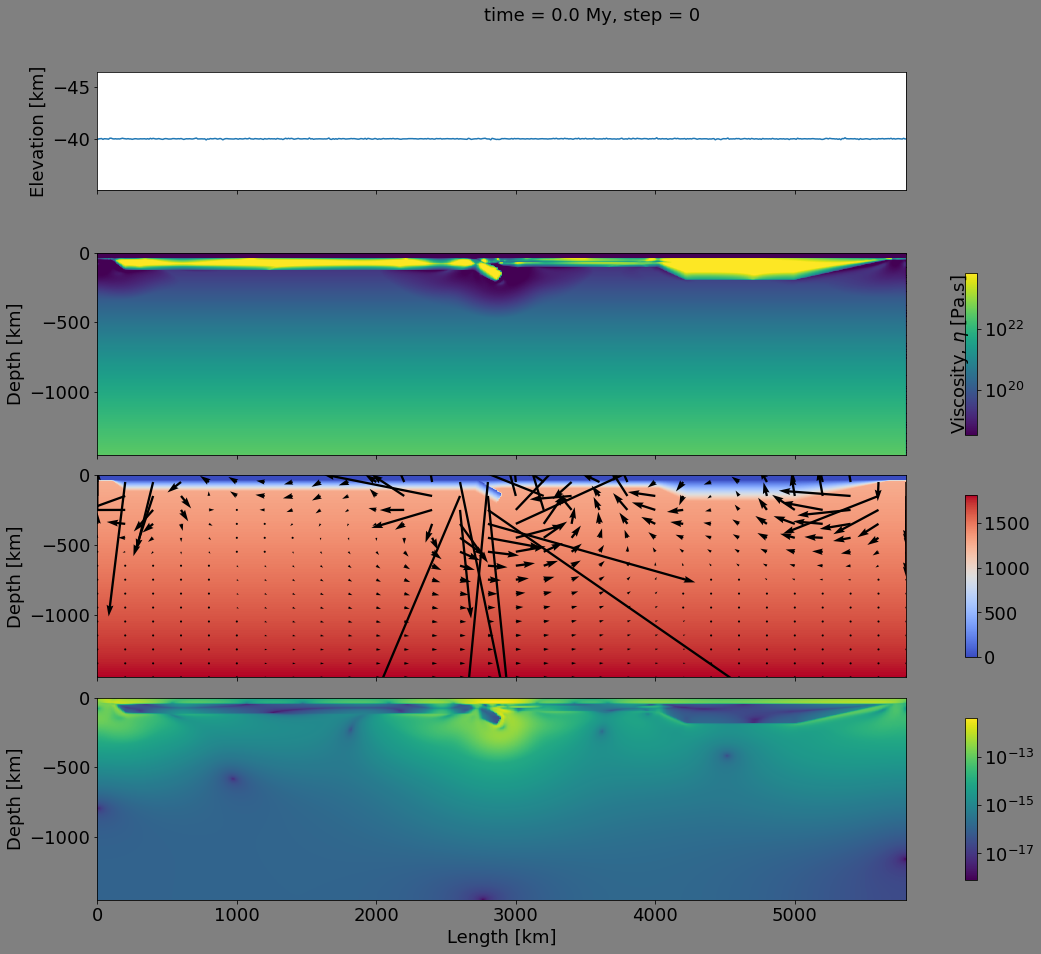

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox

aux = 0
if ("temperature" or ("velocity_x" and "velocity_x")) in dataset.data_vars:
    aux += 1
    # if "temperature" in dataset.data_vars:
    #     aux += 1
    # if ("velocity_x" and "velocity_x") in dataset.data_vars:
    #     aux += 1
if "strain_rate" in dataset.data_vars:
    vmin, vmax = dataset.strain_rate.min(), dataset.strain_rate.max()
    aux += 1
if "viscosity" in dataset.data_vars:
    aux += 1
if "surface" in dataset.data_vars:
    wmin, wmax = dataset.surface.min()/1.0e3, dataset.surface.max()/1.0e3
    aux += 1

hspace = 0.1

# font = {'size' : 20}
# font = {'size'   : 18}

# matplotlib.
# rc('font', **font)

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
for i in range(0,1):
    fig_num = 0
    per = np.round(100*(i+1)/(dataset.time.size-1),2)
    print(f'{per:.2f}%', end='\r')

    data = dataset.isel(time=i)
    
    fig, axs = plt.subplots(aux, 1, figsize=(20, aux*4), sharex=True, facecolor="grey")
    fig.subplots_adjust(hspace=hspace)

    if "surface" in dataset.data_vars:
        im1 = axs[fig_num].plot(data.surface.x/1.0e3, data.surface/1.0e3)
        axs[fig_num].set_ylim(wmax, wmin)
        axs[fig_num].set_ylabel("Elevation [km]")
        surface_fig_num = fig_num
        fig_num += 1
    
    if "viscosity" in dataset.data_vars:
        im = axs[fig_num].imshow(data.viscosity.T[::-1], cmap="viridis", norm=LogNorm(), extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
        cax = inset_axes(axs[fig_num], width="5%", height="80%", loc='center left', bbox_to_anchor=(1.05, 0., 0.3, 1), bbox_transform=axs[fig_num].transAxes, borderpad=1)
        axs[fig_num].set_aspect("equal")
        axs[fig_num].set_ylabel("Depth [km]")
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label('Viscosity, $\eta$ [Pa.s]', rotation=90, labelpad=labelpad)
        imshow_box = np.array(axs[fig_num].get_position())
        fig_num += 1
        
    if ("temperature" or ("velocity_x" and "velocity_x")) in dataset.data_vars:
        if "temperature" in dataset.data_vars:
            im = axs[fig_num].imshow(data.temperature.T[::-1], cmap="coolwarm", extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
            cax = inset_axes(axs[fig_num], width="5%", height="80%", loc='center left', bbox_to_anchor=(1.05, 0., 0.3, 1), bbox_transform=axs[fig_num].transAxes, borderpad=1)
            fig.colorbar(im, cax=cax)
        if ("velocity_x" and "velocity_x") in dataset.data_vars:
            vel_aux = data[dict(x=slice(None, None, 20), z=slice(None, None, 20))]
            im = axs[fig_num].quiver(vel_aux.x/1.0e3, vel_aux.z/1.0e3, vel_aux.velocity_x.values.T, vel_aux.velocity_z.values.T) 
        axs[fig_num].set_aspect("equal")
        axs[fig_num].set_ylabel("Depth [km]")
        imshow_box = np.array(axs[fig_num].get_position())
        fig_num += 1

    if "strain_rate" in dataset.data_vars:
        im = axs[fig_num].imshow(data.strain_rate.T[::-1], cmap="viridis", norm=LogNorm(), extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3])
        cax = inset_axes(axs[fig_num], width="5%", height="80%", loc='center left', bbox_to_anchor=(1.05, 0., 0.3, 1), bbox_transform=axs[fig_num].transAxes, borderpad=1)
        axs[fig_num].set_aspect("equal")
        axs[fig_num].set_ylabel("Depth [km]")
        fig.colorbar(im, cax=cax)
        imshow_box = np.array(axs[fig_num].get_position())
        fig_num += 1
        
    # Fix surface plot aspect ration and position
    if "surface" in dataset.data_vars:
        plot_box = np.array(axs[surface_fig_num].get_position())    
        axs[surface_fig_num].set_aspect(75)
        new_plot_box = Bbox([[imshow_box[0, 0], plot_box[0, 1]], [imshow_box[1, 0], plot_box[1, 1]]])
        axs[surface_fig_num].set_position(new_plot_box)
    
    axs[fig_num-1].set_xlabel("Length [km]")
    plt.suptitle(f"time = {np.round(data.time.item(), 2)} My, step = {data.step.item()}", ha='left', y=0.9)
    